In [2]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-21 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
sklearn 0.21.3
konlpy 0.5.1
tensorflow 1.14.0
matplotlib 3.0.3
imblearn 0.5.0


Using TensorFlow backend.


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle

# Load datasets

In [5]:
datasets = pd.read_csv('train.csv',encoding='utf-16')
datasets.head()

,Unnamed: 0,comment,url_id,label
0,0,ㅜㅜ,77,0
1,1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,17,0
2,2,헐,52,0
3,3,제시,75,0
4,4,이거인 듯,18,0


In [6]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 4 columns):
Unnamed: 0    42000 non-null int64
comment       42000 non-null object
url_id        42000 non-null int64
label         42000 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [7]:
morped =[_.encode('utf-8') for _ in tqdm(datasets.comment)]
morped

100%|██████████| 42000/42000 [00:00<00:00, 1000015.71it/s]


[b'\xe3\x85\x9c\xe3\x85\x9c',
 b'\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b',
 b'\xed\x97\x90',
 b'\xec\xa0\x9c\xec\x8b\x9c',
 b'\xec\x9d\xb4\xea\xb1\xb0\xec\x9d\xb8 \xeb\x93\xaf',
 b'\xea\xb0\x9c\xec\x8d\xa8\xea\xb8\x80\xea\xb2\x9c',
 b'\xe3\x85\x87\xe3\x85\x88',
 b'\xec\x86\x90 \xec\xb0\xa7\xec\x9c\xbc\xeb\xa9\xb4 \xec\xa7\x84\xec\xa7\x9c \xec\x95\x84\xed\x94\x88\xeb\x8d\xb0',
 b'\xe3\x85\x87\xec\x9a\xb0\xeb\xac\xb4 \xeb\xa7\x90\xea\xb3\xa0 \xeb\xaa\xb0\xec\x99\x95',
 b'\xea\xb7\xb8\xea\xb1\xb4 \xec\x95\x84\xeb\x8b\x88\xeb\x8d\x98\xeb\x8d\xb0',
 b'\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x85\x8b\xe3\x

In [8]:
bytarr = []
[bytarr.append([str(_) for _ in morped[i]]) for i in range(len(morped))]
bytarr

[['227', '133', '156', '227', '133', '156'],
 ['227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139',
  '227',
  '133',
  '139'],
 ['237', '151', '144'],
 ['236', '160', '156', '236', '139', '156'],
 ['236',
  '157',
  '180',
  '234',
  '177',
  '176',
  '236',
  '157',
  '184',
  '32',
  '235',
  '147',
  '175'],
 ['234',
  '176',
  '156',
  '236',
  '141',
  '168',
  '234',
  '184',
  '128',
  '234',
  '178',
  '156'],
 ['227', '133', '135', '227', '133', '136'],
 ['236',
  '134',
  '144',
  '32',
  '236',
  '

# 형태소분석

In [9]:
vocab_size = 30000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

    vocab = {
    '<PAD>': pad_id,
    '<OOV>': oov_id
    }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[str(word)] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(bytarr)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# # vocab save
# with open('./vocab/vocab_index.pickle', 'wb') as f:
#     pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
# with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
#     pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
133 :  94992
227 :  94926
139 :  94675
236 :  85378
235 :  70509
32 :  42738
132 :  25626
234 :  24976
180 :  21650
176 :  21395

단어 사전:
0 <PAD>
1 <OOV>
2 133
3 227
4 139
5 236
6 235
7 32
8 132
9 234

단어 사전 크기:  175


In [11]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", bytarr[0])
ids = text_to_index(bytarr[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['227', '133', '156', '227', '133', '156']
문자 -> 숫자:  [3, 2, 19, 3, 2, 19]
숫자 -> 문자:  227 133 156 227 133 156


In [12]:
x_variable = [text_to_index(_) for _ in bytarr]

sentence_size = 50
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [13]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [14]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

In [16]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE

In [17]:
up_X, up_y = RandomOverSampler().fit_resample(X_train, y_train)

# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(59934, 29967)

In [18]:
model_up = keras.Sequential([
    keras.layers.Embedding(30000, 10),
    keras.layers.Conv1D(64, 4, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

W0821 01:06:58.020705 25136 deprecation.py:506] From C:\Users\KimJJ\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0821 01:06:58.024722 25136 deprecation.py:506] From C:\Users\KimJJ\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
C:\Users\KimJJ\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will s

W0821 01:07:04.439725 25136 deprecation.py:323] From C:\Users\KimJJ\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 59934 samples, validate on 10500 samples
Epoch 1/5


16832/59934 [=======>......................] - ETA: 14:21 - loss: 0.6927 - recall: 0.718 - ETA: 4:05 - loss: 0.6931 - recall: 0.625 - ETA: 2:37 - loss: 0.6929 - recall: 0.59 - ETA: 2:02 - loss: 0.6934 - recall: 0.59 - ETA: 1:43 - loss: 0.6932 - recall: 0.59 - ETA: 1:36 - loss: 0.6934 - recall: 0.58 - ETA: 1:27 - loss: 0.6932 - recall: 0.57 - ETA: 1:20 - loss: 0.6937 - recall: 0.55 - ETA: 1:15 - loss: 0.6935 - recall: 0.54 - ETA: 1:11 - loss: 0.6934 - recall: 0.54 - ETA: 1:08 - loss: 0.6936 - recall: 0.53 - ETA: 1:06 - loss: 0.6930 - recall: 0.54 - ETA: 1:05 - loss: 0.6932 - recall: 0.53 - ETA: 1:05 - loss: 0.6930 - recall: 0.53 - ETA: 1:04 - loss: 0.6929 - recall: 0.53 - ETA: 1:03 - loss: 0.6928 - recall: 0.53 - ETA: 1:02 - loss: 0.6929 - recall: 0.53 - ETA: 1:01 - loss: 0.6936 - recall: 0.53 - ETA: 59s - loss: 0.6940 - recall: 0.5267 - ETA: 58s - loss: 0.6938 - recall: 0.526 - ETA: 57s - loss: 0.6937 - recall: 0.528 - ETA: 57s - loss: 0.6937 - recall: 0.526 - ETA: 56s - loss: 0.6937 -

34784/59934 [================>.............] - ETA: 31s - loss: 0.6917 - recall: 0.485 - ETA: 31s - loss: 0.6917 - recall: 0.485 - ETA: 30s - loss: 0.6916 - recall: 0.485 - ETA: 30s - loss: 0.6916 - recall: 0.485 - ETA: 30s - loss: 0.6916 - recall: 0.486 - ETA: 30s - loss: 0.6916 - recall: 0.486 - ETA: 30s - loss: 0.6916 - recall: 0.486 - ETA: 30s - loss: 0.6916 - recall: 0.487 - ETA: 30s - loss: 0.6915 - recall: 0.487 - ETA: 30s - loss: 0.6915 - recall: 0.487 - ETA: 30s - loss: 0.6915 - recall: 0.488 - ETA: 30s - loss: 0.6915 - recall: 0.488 - ETA: 30s - loss: 0.6914 - recall: 0.489 - ETA: 29s - loss: 0.6914 - recall: 0.489 - ETA: 29s - loss: 0.6915 - recall: 0.489 - ETA: 29s - loss: 0.6914 - recall: 0.489 - ETA: 29s - loss: 0.6913 - recall: 0.490 - ETA: 29s - loss: 0.6913 - recall: 0.490 - ETA: 29s - loss: 0.6913 - recall: 0.490 - ETA: 29s - loss: 0.6914 - recall: 0.490 - ETA: 29s - loss: 0.6913 - recall: 0.491 - ETA: 29s - loss: 0.6912 - recall: 0.491 - ETA: 29s - loss: 0.6911 - rec

53568/59934 [=========================>....] - ETA: 17s - loss: 0.6864 - recall: 0.524 - ETA: 17s - loss: 0.6864 - recall: 0.524 - ETA: 17s - loss: 0.6864 - recall: 0.525 - ETA: 17s - loss: 0.6863 - recall: 0.525 - ETA: 16s - loss: 0.6863 - recall: 0.525 - ETA: 16s - loss: 0.6864 - recall: 0.525 - ETA: 16s - loss: 0.6864 - recall: 0.525 - ETA: 16s - loss: 0.6864 - recall: 0.525 - ETA: 16s - loss: 0.6863 - recall: 0.525 - ETA: 16s - loss: 0.6863 - recall: 0.525 - ETA: 16s - loss: 0.6862 - recall: 0.525 - ETA: 16s - loss: 0.6862 - recall: 0.526 - ETA: 16s - loss: 0.6861 - recall: 0.526 - ETA: 16s - loss: 0.6862 - recall: 0.526 - ETA: 16s - loss: 0.6862 - recall: 0.526 - ETA: 16s - loss: 0.6862 - recall: 0.526 - ETA: 16s - loss: 0.6862 - recall: 0.526 - ETA: 16s - loss: 0.6862 - recall: 0.526 - ETA: 16s - loss: 0.6862 - recall: 0.526 - ETA: 16s - loss: 0.6862 - recall: 0.527 - ETA: 15s - loss: 0.6862 - recall: 0.526 - ETA: 15s - loss: 0.6862 - recall: 0.526 - ETA: 15s - loss: 0.6862 - rec

59934/59934 [==============================] - ETA: 4s - loss: 0.6835 - recall: 0.54 - ETA: 4s - loss: 0.6834 - recall: 0.54 - ETA: 4s - loss: 0.6834 - recall: 0.54 - ETA: 4s - loss: 0.6834 - recall: 0.54 - ETA: 3s - loss: 0.6833 - recall: 0.54 - ETA: 3s - loss: 0.6833 - recall: 0.54 - ETA: 3s - loss: 0.6833 - recall: 0.54 - ETA: 3s - loss: 0.6833 - recall: 0.54 - ETA: 3s - loss: 0.6832 - recall: 0.54 - ETA: 3s - loss: 0.6832 - recall: 0.54 - ETA: 3s - loss: 0.6833 - recall: 0.54 - ETA: 3s - loss: 0.6832 - recall: 0.54 - ETA: 3s - loss: 0.6832 - recall: 0.54 - ETA: 3s - loss: 0.6831 - recall: 0.54 - ETA: 3s - loss: 0.6831 - recall: 0.54 - ETA: 3s - loss: 0.6830 - recall: 0.54 - ETA: 3s - loss: 0.6830 - recall: 0.54 - ETA: 3s - loss: 0.6830 - recall: 0.54 - ETA: 3s - loss: 0.6830 - recall: 0.54 - ETA: 2s - loss: 0.6830 - recall: 0.54 - ETA: 2s - loss: 0.6829 - recall: 0.54 - ETA: 2s - loss: 0.6829 - recall: 0.54 - ETA: 2s - loss: 0.6829 - recall: 0.54 - ETA: 2s - loss: 0.6828 - recall: 

18272/59934 [========>.....................] - ETA: 48s - loss: 0.6623 - recall: 0.656 - ETA: 42s - loss: 0.6815 - recall: 0.632 - ETA: 40s - loss: 0.6961 - recall: 0.598 - ETA: 40s - loss: 0.6856 - recall: 0.612 - ETA: 40s - loss: 0.6887 - recall: 0.601 - ETA: 39s - loss: 0.6867 - recall: 0.587 - ETA: 39s - loss: 0.6861 - recall: 0.583 - ETA: 39s - loss: 0.6814 - recall: 0.593 - ETA: 39s - loss: 0.6781 - recall: 0.597 - ETA: 39s - loss: 0.6771 - recall: 0.596 - ETA: 39s - loss: 0.6767 - recall: 0.594 - ETA: 38s - loss: 0.6756 - recall: 0.590 - ETA: 38s - loss: 0.6781 - recall: 0.584 - ETA: 38s - loss: 0.6776 - recall: 0.580 - ETA: 38s - loss: 0.6747 - recall: 0.582 - ETA: 38s - loss: 0.6797 - recall: 0.576 - ETA: 38s - loss: 0.6796 - recall: 0.570 - ETA: 37s - loss: 0.6798 - recall: 0.569 - ETA: 37s - loss: 0.6801 - recall: 0.565 - ETA: 37s - loss: 0.6796 - recall: 0.561 - ETA: 37s - loss: 0.6785 - recall: 0.564 - ETA: 37s - loss: 0.6772 - recall: 0.565 - ETA: 37s - loss: 0.6759 - rec

36576/59934 [=================>............] - ETA: 26s - loss: 0.6659 - recall: 0.596 - ETA: 26s - loss: 0.6660 - recall: 0.596 - ETA: 26s - loss: 0.6660 - recall: 0.596 - ETA: 26s - loss: 0.6656 - recall: 0.597 - ETA: 26s - loss: 0.6654 - recall: 0.598 - ETA: 26s - loss: 0.6653 - recall: 0.598 - ETA: 26s - loss: 0.6651 - recall: 0.598 - ETA: 26s - loss: 0.6650 - recall: 0.598 - ETA: 26s - loss: 0.6652 - recall: 0.598 - ETA: 26s - loss: 0.6650 - recall: 0.598 - ETA: 26s - loss: 0.6651 - recall: 0.598 - ETA: 26s - loss: 0.6651 - recall: 0.598 - ETA: 25s - loss: 0.6650 - recall: 0.598 - ETA: 25s - loss: 0.6652 - recall: 0.598 - ETA: 25s - loss: 0.6650 - recall: 0.598 - ETA: 25s - loss: 0.6651 - recall: 0.598 - ETA: 25s - loss: 0.6651 - recall: 0.598 - ETA: 25s - loss: 0.6652 - recall: 0.598 - ETA: 25s - loss: 0.6651 - recall: 0.598 - ETA: 25s - loss: 0.6653 - recall: 0.598 - ETA: 25s - loss: 0.6652 - recall: 0.598 - ETA: 25s - loss: 0.6651 - recall: 0.598 - ETA: 25s - loss: 0.6651 - rec

54592/59934 [==========================>...] - ETA: 15s - loss: 0.6613 - recall: 0.605 - ETA: 14s - loss: 0.6611 - recall: 0.605 - ETA: 14s - loss: 0.6611 - recall: 0.605 - ETA: 14s - loss: 0.6612 - recall: 0.605 - ETA: 14s - loss: 0.6612 - recall: 0.605 - ETA: 14s - loss: 0.6612 - recall: 0.605 - ETA: 14s - loss: 0.6610 - recall: 0.606 - ETA: 14s - loss: 0.6610 - recall: 0.605 - ETA: 14s - loss: 0.6609 - recall: 0.606 - ETA: 14s - loss: 0.6607 - recall: 0.606 - ETA: 14s - loss: 0.6607 - recall: 0.606 - ETA: 14s - loss: 0.6608 - recall: 0.606 - ETA: 14s - loss: 0.6608 - recall: 0.606 - ETA: 14s - loss: 0.6607 - recall: 0.606 - ETA: 14s - loss: 0.6607 - recall: 0.606 - ETA: 14s - loss: 0.6607 - recall: 0.606 - ETA: 14s - loss: 0.6607 - recall: 0.606 - ETA: 13s - loss: 0.6606 - recall: 0.607 - ETA: 13s - loss: 0.6605 - recall: 0.607 - ETA: 13s - loss: 0.6604 - recall: 0.607 - ETA: 13s - loss: 0.6603 - recall: 0.607 - ETA: 13s - loss: 0.6603 - recall: 0.607 - ETA: 13s - loss: 0.6603 - rec

59934/59934 [==============================] - ETA: 3s - loss: 0.6577 - recall: 0.61 - ETA: 3s - loss: 0.6577 - recall: 0.61 - ETA: 3s - loss: 0.6577 - recall: 0.61 - ETA: 3s - loss: 0.6577 - recall: 0.61 - ETA: 3s - loss: 0.6577 - recall: 0.61 - ETA: 3s - loss: 0.6577 - recall: 0.61 - ETA: 3s - loss: 0.6578 - recall: 0.61 - ETA: 3s - loss: 0.6578 - recall: 0.61 - ETA: 2s - loss: 0.6577 - recall: 0.61 - ETA: 2s - loss: 0.6576 - recall: 0.61 - ETA: 2s - loss: 0.6576 - recall: 0.61 - ETA: 2s - loss: 0.6575 - recall: 0.61 - ETA: 2s - loss: 0.6574 - recall: 0.61 - ETA: 2s - loss: 0.6574 - recall: 0.61 - ETA: 2s - loss: 0.6573 - recall: 0.61 - ETA: 2s - loss: 0.6573 - recall: 0.61 - ETA: 2s - loss: 0.6574 - recall: 0.61 - ETA: 2s - loss: 0.6574 - recall: 0.61 - ETA: 2s - loss: 0.6573 - recall: 0.61 - ETA: 2s - loss: 0.6573 - recall: 0.61 - ETA: 2s - loss: 0.6573 - recall: 0.61 - ETA: 2s - loss: 0.6573 - recall: 0.61 - ETA: 2s - loss: 0.6573 - recall: 0.61 - ETA: 2s - loss: 0.6574 - recall: 

16704/59934 [=======>......................] - ETA: 41s - loss: 0.6049 - recall: 0.781 - ETA: 38s - loss: 0.6869 - recall: 0.648 - ETA: 37s - loss: 0.6735 - recall: 0.629 - ETA: 37s - loss: 0.6542 - recall: 0.653 - ETA: 37s - loss: 0.6474 - recall: 0.656 - ETA: 37s - loss: 0.6380 - recall: 0.664 - ETA: 37s - loss: 0.6395 - recall: 0.654 - ETA: 38s - loss: 0.6469 - recall: 0.649 - ETA: 38s - loss: 0.6508 - recall: 0.638 - ETA: 38s - loss: 0.6474 - recall: 0.646 - ETA: 38s - loss: 0.6497 - recall: 0.638 - ETA: 38s - loss: 0.6512 - recall: 0.628 - ETA: 38s - loss: 0.6477 - recall: 0.630 - ETA: 38s - loss: 0.6511 - recall: 0.620 - ETA: 38s - loss: 0.6502 - recall: 0.620 - ETA: 38s - loss: 0.6501 - recall: 0.623 - ETA: 38s - loss: 0.6498 - recall: 0.622 - ETA: 38s - loss: 0.6482 - recall: 0.623 - ETA: 38s - loss: 0.6480 - recall: 0.622 - ETA: 38s - loss: 0.6485 - recall: 0.621 - ETA: 37s - loss: 0.6483 - recall: 0.624 - ETA: 37s - loss: 0.6494 - recall: 0.622 - ETA: 37s - loss: 0.6481 - rec

34624/59934 [================>.............] - ETA: 30s - loss: 0.6458 - recall: 0.628 - ETA: 29s - loss: 0.6457 - recall: 0.628 - ETA: 29s - loss: 0.6458 - recall: 0.628 - ETA: 29s - loss: 0.6460 - recall: 0.628 - ETA: 29s - loss: 0.6459 - recall: 0.628 - ETA: 29s - loss: 0.6459 - recall: 0.628 - ETA: 29s - loss: 0.6457 - recall: 0.628 - ETA: 29s - loss: 0.6456 - recall: 0.628 - ETA: 29s - loss: 0.6454 - recall: 0.629 - ETA: 29s - loss: 0.6454 - recall: 0.628 - ETA: 29s - loss: 0.6457 - recall: 0.628 - ETA: 29s - loss: 0.6456 - recall: 0.628 - ETA: 29s - loss: 0.6456 - recall: 0.628 - ETA: 28s - loss: 0.6455 - recall: 0.628 - ETA: 28s - loss: 0.6456 - recall: 0.627 - ETA: 28s - loss: 0.6453 - recall: 0.628 - ETA: 28s - loss: 0.6452 - recall: 0.628 - ETA: 28s - loss: 0.6451 - recall: 0.628 - ETA: 28s - loss: 0.6448 - recall: 0.628 - ETA: 28s - loss: 0.6447 - recall: 0.629 - ETA: 28s - loss: 0.6448 - recall: 0.629 - ETA: 28s - loss: 0.6447 - recall: 0.629 - ETA: 28s - loss: 0.6448 - rec

53504/59934 [=========================>....] - ETA: 17s - loss: 0.6412 - recall: 0.633 - ETA: 16s - loss: 0.6412 - recall: 0.633 - ETA: 16s - loss: 0.6412 - recall: 0.633 - ETA: 16s - loss: 0.6411 - recall: 0.633 - ETA: 16s - loss: 0.6412 - recall: 0.633 - ETA: 16s - loss: 0.6413 - recall: 0.633 - ETA: 16s - loss: 0.6414 - recall: 0.633 - ETA: 16s - loss: 0.6413 - recall: 0.633 - ETA: 16s - loss: 0.6412 - recall: 0.632 - ETA: 16s - loss: 0.6414 - recall: 0.632 - ETA: 16s - loss: 0.6414 - recall: 0.632 - ETA: 16s - loss: 0.6415 - recall: 0.632 - ETA: 16s - loss: 0.6415 - recall: 0.632 - ETA: 16s - loss: 0.6414 - recall: 0.632 - ETA: 16s - loss: 0.6413 - recall: 0.632 - ETA: 16s - loss: 0.6413 - recall: 0.632 - ETA: 15s - loss: 0.6411 - recall: 0.633 - ETA: 15s - loss: 0.6411 - recall: 0.632 - ETA: 15s - loss: 0.6411 - recall: 0.632 - ETA: 15s - loss: 0.6409 - recall: 0.633 - ETA: 15s - loss: 0.6410 - recall: 0.632 - ETA: 15s - loss: 0.6410 - recall: 0.632 - ETA: 15s - loss: 0.6411 - rec

59934/59934 [==============================] - ETA: 4s - loss: 0.6393 - recall: 0.63 - ETA: 4s - loss: 0.6392 - recall: 0.63 - ETA: 4s - loss: 0.6393 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6393 - recall: 0.63 - ETA: 3s - loss: 0.6392 - recall: 0.63 - ETA: 3s - loss: 0.6391 - recall: 0.63 - ETA: 3s - loss: 0.6391 - recall: 0.63 - ETA: 3s - loss: 0.6391 - recall: 0.63 - ETA: 3s - loss: 0.6391 - recall: 0.63 - ETA: 3s - loss: 0.6391 - recall: 0.63 - ETA: 3s - loss: 0.6391 - recall: 0.63 - ETA: 3s - loss: 0.6391 - recall: 0.63 - ETA: 2s - loss: 0.6392 - recall: 0.63 - ETA: 2s - loss: 0.6391 - recall: 0.63 - ETA: 2s - loss: 0.6391 - recall: 0.63 - ETA: 2s - loss: 0.6392 - recall: 0.63 - ETA: 2s - loss: 0.6390 - recall: 

18400/59934 [========>.....................] - ETA: 44s - loss: 0.6503 - recall: 0.656 - ETA: 42s - loss: 0.6181 - recall: 0.664 - ETA: 40s - loss: 0.6104 - recall: 0.656 - ETA: 38s - loss: 0.6251 - recall: 0.646 - ETA: 38s - loss: 0.6175 - recall: 0.656 - ETA: 38s - loss: 0.6165 - recall: 0.660 - ETA: 38s - loss: 0.6121 - recall: 0.661 - ETA: 38s - loss: 0.6169 - recall: 0.653 - ETA: 37s - loss: 0.6190 - recall: 0.647 - ETA: 37s - loss: 0.6193 - recall: 0.652 - ETA: 37s - loss: 0.6265 - recall: 0.650 - ETA: 37s - loss: 0.6221 - recall: 0.653 - ETA: 37s - loss: 0.6217 - recall: 0.652 - ETA: 37s - loss: 0.6189 - recall: 0.653 - ETA: 37s - loss: 0.6229 - recall: 0.653 - ETA: 37s - loss: 0.6230 - recall: 0.650 - ETA: 37s - loss: 0.6195 - recall: 0.656 - ETA: 37s - loss: 0.6176 - recall: 0.660 - ETA: 37s - loss: 0.6203 - recall: 0.658 - ETA: 37s - loss: 0.6195 - recall: 0.656 - ETA: 37s - loss: 0.6190 - recall: 0.659 - ETA: 37s - loss: 0.6221 - recall: 0.657 - ETA: 36s - loss: 0.6209 - rec

36544/59934 [=================>............] - ETA: 26s - loss: 0.6284 - recall: 0.646 - ETA: 26s - loss: 0.6288 - recall: 0.645 - ETA: 26s - loss: 0.6293 - recall: 0.645 - ETA: 26s - loss: 0.6294 - recall: 0.645 - ETA: 26s - loss: 0.6294 - recall: 0.645 - ETA: 25s - loss: 0.6294 - recall: 0.645 - ETA: 25s - loss: 0.6294 - recall: 0.645 - ETA: 25s - loss: 0.6294 - recall: 0.645 - ETA: 25s - loss: 0.6294 - recall: 0.645 - ETA: 25s - loss: 0.6291 - recall: 0.645 - ETA: 25s - loss: 0.6290 - recall: 0.645 - ETA: 25s - loss: 0.6288 - recall: 0.645 - ETA: 25s - loss: 0.6287 - recall: 0.645 - ETA: 25s - loss: 0.6290 - recall: 0.645 - ETA: 25s - loss: 0.6289 - recall: 0.645 - ETA: 25s - loss: 0.6287 - recall: 0.645 - ETA: 25s - loss: 0.6289 - recall: 0.645 - ETA: 25s - loss: 0.6292 - recall: 0.645 - ETA: 25s - loss: 0.6291 - recall: 0.645 - ETA: 25s - loss: 0.6291 - recall: 0.645 - ETA: 25s - loss: 0.6290 - recall: 0.645 - ETA: 25s - loss: 0.6290 - recall: 0.645 - ETA: 25s - loss: 0.6293 - rec

54464/59934 [==========================>...] - ETA: 14s - loss: 0.6283 - recall: 0.644 - ETA: 14s - loss: 0.6282 - recall: 0.644 - ETA: 14s - loss: 0.6281 - recall: 0.644 - ETA: 14s - loss: 0.6280 - recall: 0.644 - ETA: 14s - loss: 0.6279 - recall: 0.645 - ETA: 14s - loss: 0.6278 - recall: 0.645 - ETA: 14s - loss: 0.6279 - recall: 0.645 - ETA: 14s - loss: 0.6279 - recall: 0.645 - ETA: 14s - loss: 0.6281 - recall: 0.645 - ETA: 14s - loss: 0.6281 - recall: 0.645 - ETA: 14s - loss: 0.6280 - recall: 0.645 - ETA: 14s - loss: 0.6282 - recall: 0.644 - ETA: 14s - loss: 0.6282 - recall: 0.644 - ETA: 14s - loss: 0.6284 - recall: 0.644 - ETA: 14s - loss: 0.6285 - recall: 0.644 - ETA: 14s - loss: 0.6285 - recall: 0.644 - ETA: 13s - loss: 0.6285 - recall: 0.644 - ETA: 13s - loss: 0.6284 - recall: 0.644 - ETA: 13s - loss: 0.6284 - recall: 0.644 - ETA: 13s - loss: 0.6284 - recall: 0.644 - ETA: 13s - loss: 0.6283 - recall: 0.644 - ETA: 13s - loss: 0.6286 - recall: 0.644 - ETA: 13s - loss: 0.6285 - rec

59934/59934 [==============================] - ETA: 3s - loss: 0.6281 - recall: 0.64 - ETA: 3s - loss: 0.6281 - recall: 0.64 - ETA: 3s - loss: 0.6282 - recall: 0.64 - ETA: 3s - loss: 0.6281 - recall: 0.64 - ETA: 3s - loss: 0.6281 - recall: 0.64 - ETA: 3s - loss: 0.6281 - recall: 0.64 - ETA: 3s - loss: 0.6282 - recall: 0.64 - ETA: 3s - loss: 0.6283 - recall: 0.64 - ETA: 3s - loss: 0.6283 - recall: 0.64 - ETA: 2s - loss: 0.6283 - recall: 0.64 - ETA: 2s - loss: 0.6282 - recall: 0.64 - ETA: 2s - loss: 0.6282 - recall: 0.64 - ETA: 2s - loss: 0.6282 - recall: 0.64 - ETA: 2s - loss: 0.6281 - recall: 0.64 - ETA: 2s - loss: 0.6282 - recall: 0.64 - ETA: 2s - loss: 0.6282 - recall: 0.64 - ETA: 2s - loss: 0.6282 - recall: 0.64 - ETA: 2s - loss: 0.6281 - recall: 0.64 - ETA: 2s - loss: 0.6280 - recall: 0.64 - ETA: 2s - loss: 0.6280 - recall: 0.64 - ETA: 2s - loss: 0.6280 - recall: 0.64 - ETA: 2s - loss: 0.6280 - recall: 0.64 - ETA: 2s - loss: 0.6279 - recall: 0.64 - ETA: 2s - loss: 0.6279 - recall: 

17632/59934 [=======>......................] - ETA: 43s - loss: 0.5995 - recall: 0.593 - ETA: 42s - loss: 0.6219 - recall: 0.617 - ETA: 41s - loss: 0.6564 - recall: 0.589 - ETA: 41s - loss: 0.6595 - recall: 0.600 - ETA: 41s - loss: 0.6526 - recall: 0.608 - ETA: 40s - loss: 0.6502 - recall: 0.607 - ETA: 40s - loss: 0.6486 - recall: 0.605 - ETA: 39s - loss: 0.6454 - recall: 0.609 - ETA: 39s - loss: 0.6390 - recall: 0.618 - ETA: 39s - loss: 0.6407 - recall: 0.615 - ETA: 38s - loss: 0.6407 - recall: 0.616 - ETA: 38s - loss: 0.6407 - recall: 0.623 - ETA: 38s - loss: 0.6378 - recall: 0.630 - ETA: 38s - loss: 0.6366 - recall: 0.630 - ETA: 38s - loss: 0.6368 - recall: 0.630 - ETA: 38s - loss: 0.6361 - recall: 0.631 - ETA: 38s - loss: 0.6380 - recall: 0.626 - ETA: 38s - loss: 0.6395 - recall: 0.624 - ETA: 38s - loss: 0.6359 - recall: 0.629 - ETA: 37s - loss: 0.6355 - recall: 0.628 - ETA: 37s - loss: 0.6374 - recall: 0.624 - ETA: 37s - loss: 0.6361 - recall: 0.625 - ETA: 37s - loss: 0.6336 - rec

35744/59934 [================>.............] - ETA: 28s - loss: 0.6225 - recall: 0.646 - ETA: 28s - loss: 0.6225 - recall: 0.646 - ETA: 28s - loss: 0.6230 - recall: 0.645 - ETA: 28s - loss: 0.6231 - recall: 0.645 - ETA: 28s - loss: 0.6231 - recall: 0.645 - ETA: 28s - loss: 0.6231 - recall: 0.645 - ETA: 28s - loss: 0.6232 - recall: 0.645 - ETA: 28s - loss: 0.6232 - recall: 0.645 - ETA: 27s - loss: 0.6233 - recall: 0.645 - ETA: 27s - loss: 0.6229 - recall: 0.646 - ETA: 27s - loss: 0.6230 - recall: 0.645 - ETA: 27s - loss: 0.6230 - recall: 0.645 - ETA: 27s - loss: 0.6229 - recall: 0.645 - ETA: 27s - loss: 0.6228 - recall: 0.646 - ETA: 27s - loss: 0.6224 - recall: 0.646 - ETA: 27s - loss: 0.6227 - recall: 0.646 - ETA: 27s - loss: 0.6225 - recall: 0.646 - ETA: 27s - loss: 0.6224 - recall: 0.646 - ETA: 27s - loss: 0.6221 - recall: 0.647 - ETA: 27s - loss: 0.6216 - recall: 0.647 - ETA: 27s - loss: 0.6211 - recall: 0.648 - ETA: 26s - loss: 0.6209 - recall: 0.648 - ETA: 26s - loss: 0.6208 - rec

54592/59934 [==========================>...] - ETA: 15s - loss: 0.6190 - recall: 0.652 - ETA: 15s - loss: 0.6192 - recall: 0.652 - ETA: 15s - loss: 0.6192 - recall: 0.652 - ETA: 15s - loss: 0.6193 - recall: 0.652 - ETA: 15s - loss: 0.6192 - recall: 0.652 - ETA: 15s - loss: 0.6190 - recall: 0.652 - ETA: 15s - loss: 0.6189 - recall: 0.652 - ETA: 15s - loss: 0.6191 - recall: 0.652 - ETA: 15s - loss: 0.6190 - recall: 0.652 - ETA: 15s - loss: 0.6189 - recall: 0.652 - ETA: 15s - loss: 0.6189 - recall: 0.652 - ETA: 15s - loss: 0.6188 - recall: 0.652 - ETA: 15s - loss: 0.6188 - recall: 0.652 - ETA: 15s - loss: 0.6190 - recall: 0.652 - ETA: 15s - loss: 0.6190 - recall: 0.652 - ETA: 14s - loss: 0.6191 - recall: 0.652 - ETA: 14s - loss: 0.6190 - recall: 0.652 - ETA: 14s - loss: 0.6188 - recall: 0.652 - ETA: 14s - loss: 0.6188 - recall: 0.652 - ETA: 14s - loss: 0.6189 - recall: 0.652 - ETA: 14s - loss: 0.6188 - recall: 0.653 - ETA: 14s - loss: 0.6189 - recall: 0.652 - ETA: 14s - loss: 0.6189 - rec

10500/10500 [==============================] - ETA: 0s - loss: 0.8809 - recall: 0.15 - ETA: 0s - loss: 0.8676 - recall: 0.18 - ETA: 0s - loss: 0.8697 - recall: 0.18 - ETA: 0s - loss: 0.8708 - recall: 0.18 - ETA: 0s - loss: 0.8687 - recall: 0.18 - ETA: 0s - loss: 0.8659 - recall: 0.19 - ETA: 0s - loss: 0.8675 - recall: 0.18 - ETA: 0s - loss: 0.8679 - recall: 0.18 - ETA: 0s - loss: 0.8698 - recall: 0.18 - ETA: 0s - loss: 0.8704 - recall: 0.18 - ETA: 0s - loss: 0.8714 - recall: 0.18 - ETA: 0s - loss: 0.8725 - recall: 0.18 - ETA: 0s - loss: 0.8728 - recall: 0.18 - ETA: 0s - loss: 0.8732 - recall: 0.18 - ETA: 0s - loss: 0.8717 - recall: 0.18 - ETA: 0s - loss: 0.8699 - recall: 0.18 - ETA: 0s - loss: 0.8701 - recall: 0.18 - ETA: 0s - loss: 0.8705 - recall: 0.18 - ETA: 0s - loss: 0.8690 - recall: 0.18 - 1s 89us/sample - loss: 0.8694 - recall: 0.1893
Test accuracy: 0.18933333


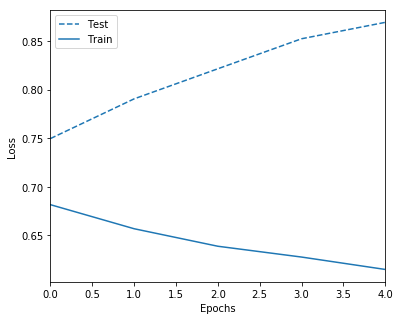

In [19]:
model_up.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_up.fit(up_X,
          pd.get_dummies(up_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_up.evaluate(X_test, pd.get_dummies(y_test))
print('Test accuracy:', test_acc)

In [20]:
print('전체채팅수{}, 유해채팅수{}'.format(len(X_test),model_up.predict_classes(X_test).sum()))

전체채팅수10500, 유해채팅수8999


### Recall

In [21]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

In [22]:
recall_score(y_test, model_up.predict_classes(X_test)),\
accuracy_score(y_test, model_up.predict_classes(X_test)),\
f1_score(y_test, model_up.predict_classes(X_test))

(0.9360568383658969, 0.18971428571428572, 0.11022798577703409)

In [ ]:
# model_up.save('../model/cnn_oversample.h5')

## Downsampling

In [48]:
down_X, down_y = RandomUnderSampler().fit_resample(X_train, y_train)

# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(3118, 1559)

In [49]:
model_down = keras.Sequential([
    keras.layers.Embedding(30000, 10),
    keras.layers.Conv1D(64, 3, padding="same", activation=tf.nn.relu,),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

Train on 3118 samples, validate on 10500 samples
Epoch 1/5
3118/3118 [==============================] - ETA: 2:55 - loss: 0.0586 - recall_1: 1.00 - ETA: 1:29 - loss: 0.0580 - recall_1: 1.00 - ETA: 45s - loss: 0.1209 - recall_1: 0.9766 - ETA: 25s - loss: 0.1338 - recall_1: 0.968 - ETA: 20s - loss: 0.1732 - recall_1: 0.954 - ETA: 15s - loss: 0.1841 - recall_1: 0.947 - ETA: 11s - loss: 0.1717 - recall_1: 0.950 - ETA: 10s - loss: 0.1586 - recall_1: 0.955 - ETA: 9s - loss: 0.1631 - recall_1: 0.957 - ETA: 7s - loss: 0.1783 - recall_1: 0.95 - ETA: 6s - loss: 0.1866 - recall_1: 0.94 - ETA: 6s - loss: 0.1909 - recall_1: 0.94 - ETA: 5s - loss: 0.1882 - recall_1: 0.94 - ETA: 4s - loss: 0.1934 - recall_1: 0.94 - ETA: 4s - loss: 0.1923 - recall_1: 0.94 - ETA: 4s - loss: 0.1891 - recall_1: 0.94 - ETA: 3s - loss: 0.1863 - recall_1: 0.94 - ETA: 3s - loss: 0.1899 - recall_1: 0.94 - ETA: 3s - loss: 0.1938 - recall_1: 0.94 - ETA: 2s - loss: 0.1954 - recall_1: 0.94 - ETA: 2s - loss: 0.1978 - recall_1: 0.9

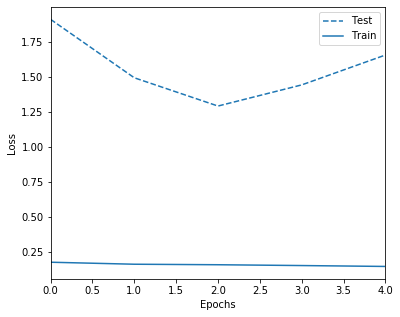

In [54]:
model_down.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_down.fit(down_X,
          pd.get_dummies(down_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_down.evaluate(X_test, pd.get_dummies(y_test))
print('Test Recall:', test_acc)

In [55]:
#recall
recall_score(y_test, model_down.predict_classes(X_test)), \
accuracy_score(y_test, model_down.predict_classes(X_test)),\
f1_score(y_test, model_down.predict_classes(X_test))

(0.633147113594041, 0.8083809523809524, 0.25260029717682014)

In [56]:
print('전체채팅수{}, 유해채팅수{}'.format(len(X_test),model_down.predict_classes(X_test).sum()))

전체채팅수10500, 유해채팅수2155


## 모델 체크포인트 저장

In [115]:
model_down.save('../model/cnn_undersample.h5')

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용